# KE5105 - Building Electrical Consumption Forecasting

# Modelling 7 - Fine-tuning model

## Summary of Findings
* **MRB building data**
* 4x128 GRU, 2x32 Dense Model
	* Dropouts (.3/.3/.3)
        * Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
	* Dropouts (.3/.3/.3) with warm restarts
        * Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
import keras.backend as K

Using TensorFlow backend.


## Load data for building mrb

In [4]:
mrb = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


## Split the data into train and test set

In [6]:
mrb_train_df = mrb[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
mrb_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29850 non-null float64
PWMMRIC2                     29850 non-null float64
BTUMochtarRiady              29447 non-null float64
PWMMRIC1_30min_avg           29817 non-null float64
PWMMRIC2_30min_avg           29817 non-null float64
BTUMochtarRiady_30min_avg    29415 non-null float64
PWM_sumadd                   29817 non-null float64
PWM_30min_avg                29860 non-null float64
BTU_sumadd                   29415 non-null float64
BTU_30min_avg                29468 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


In [8]:
mrb_test_df = mrb[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
mrb_test_df.index.max()

NaT

In [10]:
mrb_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 10 columns):
PWMMRIC1                     0 non-null float64
PWMMRIC2                     0 non-null float64
BTUMochtarRiady              0 non-null float64
PWMMRIC1_30min_avg           0 non-null float64
PWMMRIC2_30min_avg           0 non-null float64
BTUMochtarRiady_30min_avg    0 non-null float64
PWM_sumadd                   0 non-null float64
PWM_30min_avg                0 non-null float64
BTU_sumadd                   0 non-null float64
BTU_30min_avg                0 non-null float64
dtypes: float64(10)
memory usage: 0.0 bytes


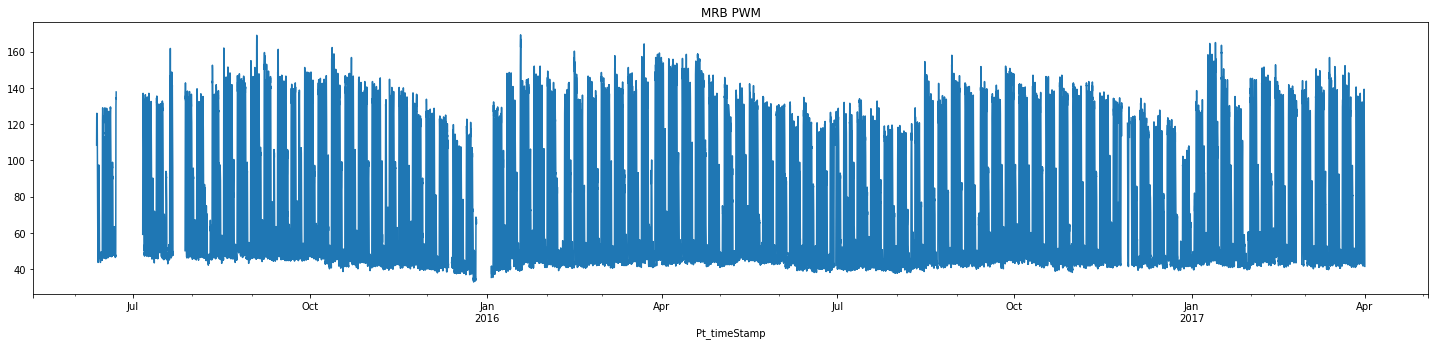

In [11]:
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

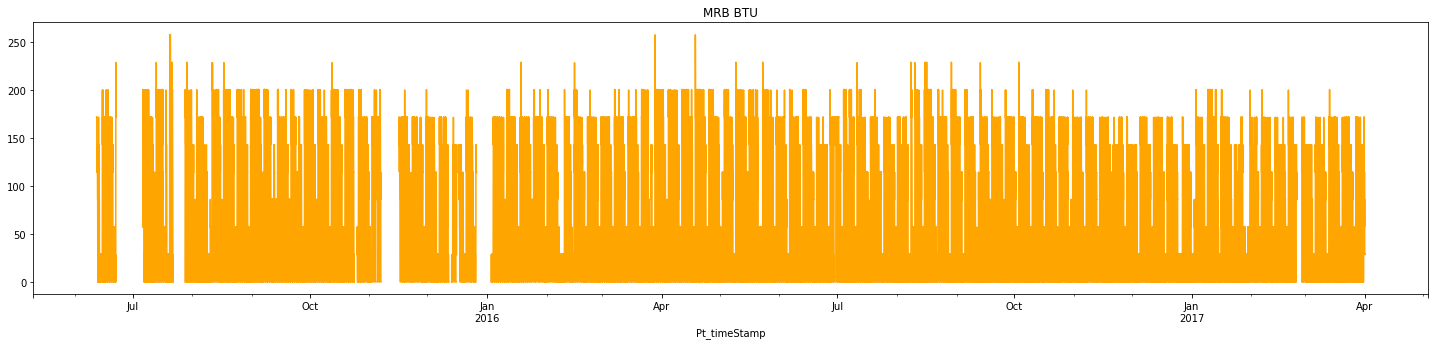

In [12]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Split a validation set out from the train set

In [13]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [14]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 10)
validation split = (11616, 10)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [15]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [16]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.55412844, 0.66699029],
       [0.60366972, 0.66601942],
       [0.63853211, 0.66601942],
       ...,
       [0.07889908, 0.11067961],
       [0.07155963, 0.        ],
       [0.05321101, 0.        ]])

In [17]:
mrb_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

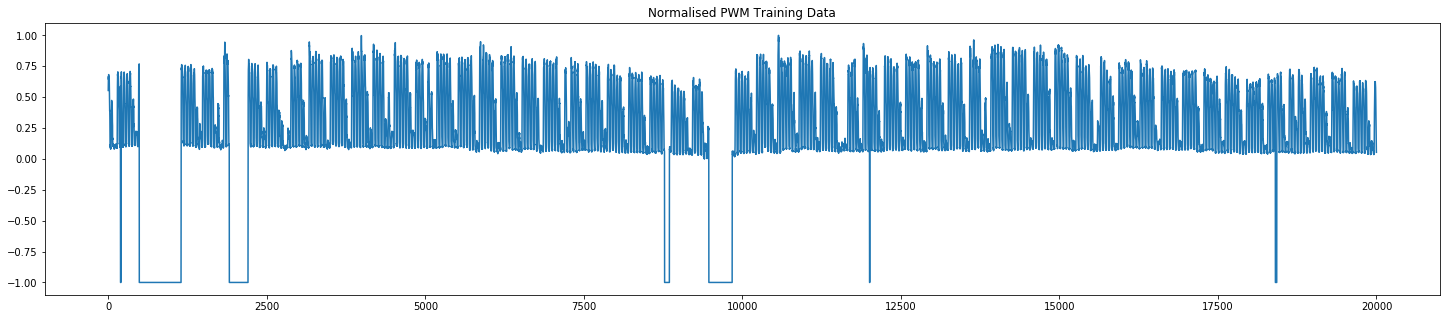

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

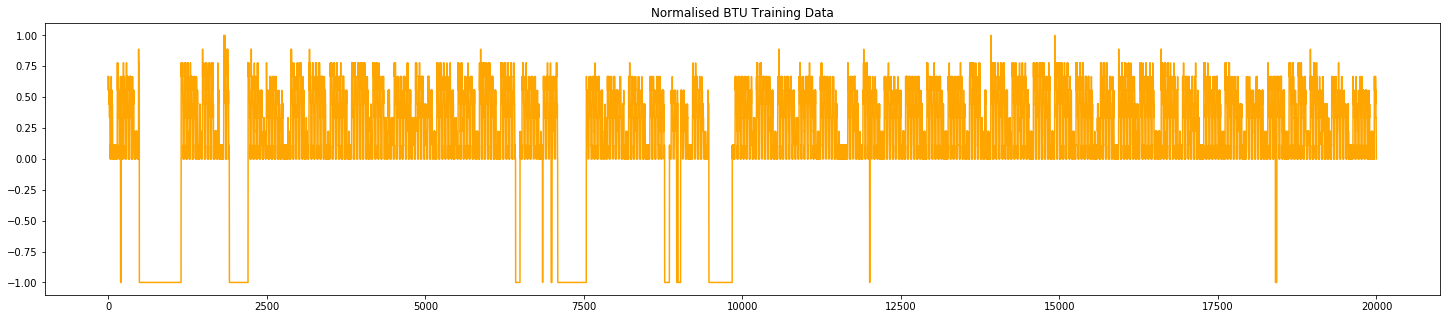

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [20]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.07155963, 0.11067961],
       [0.05688073, 0.        ],
       [0.05688073, 0.        ],
       ...,
       [0.13211009, 0.11067961],
       [0.10825688, 0.11426533],
       [0.06314127, 0.11424788]])

In [21]:
mrb_val_data.shape

(11616, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

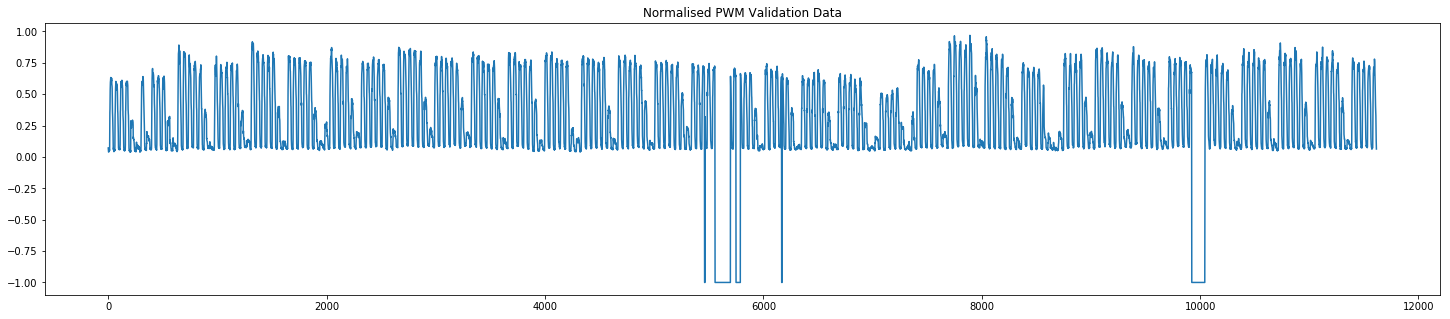

In [22]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

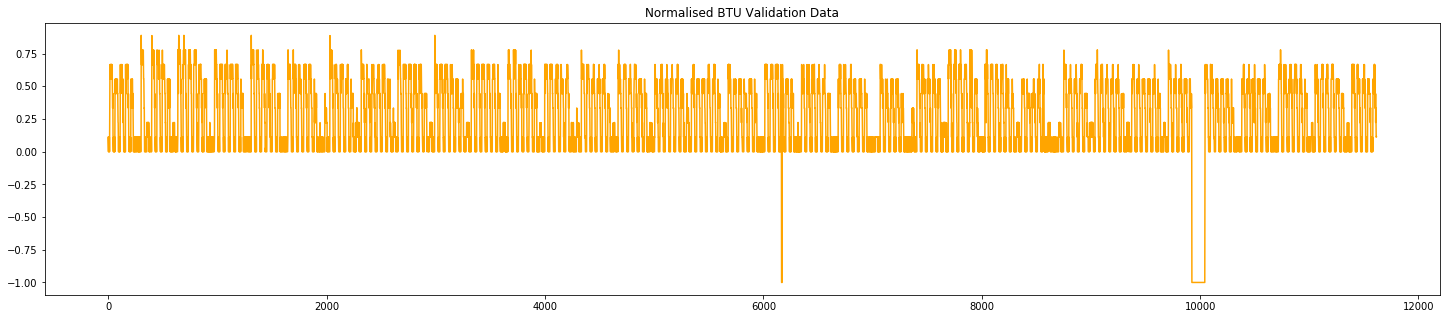

In [23]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [24]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [25]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
import tensorflow as tf
def mape_skip_zeros(y_true, y_pred):
    y_true1 = tf.boolean_mask(y_true, y_true > 0)
    y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
    diff = K.abs((y_true1 - y_pred1) / y_true1)
    return 100. * K.mean(diff, axis=-1)

## 4x128 GRU, 2x32 Dense Model with Dropouts (0.3/0.3/0.3)

In [26]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [27]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, reset_after=True))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [28]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [29]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-4x128gru-2x32dense-dropout030303.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [30]:
histories = []

In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout030303-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout030303.h5'))
model.summary()

In [31]:
train_to_epoch = 100
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-07 11:22:39.259463

Training Duration = 2:34:00.232922


In [34]:
model.save('base3mrb-4x128gru-2x32dense-dropout030303-epch' + str(train_to_epoch) + '.h5')

In [35]:
with open('base3mrb-4x128gru-2x32dense-dropout030303-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

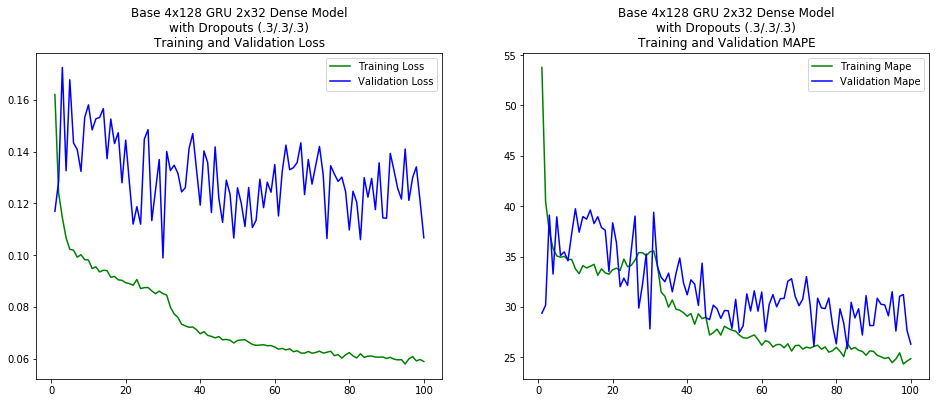

In [36]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nwith Dropouts (.3/.3/.3)\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nwith Dropouts (.3/.3/.3)\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [37]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.09892444393949526
epoch = 29


In [38]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 7.888470
Validation MAE = 13.478455


In [ ]:
# Load best model
best_model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense-dropout030303.best-epchxxx.h5'),
                       custom_objects={'mape_skip_zeros': mape_skip_zeros})
best_model.summary()

In [47]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [48]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(31616, 1)

In [51]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

In [52]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

In [ ]:
mrb_train_data.shape

In [ ]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

In [ ]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x128 GRU, 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts max_lr=.002

In [26]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [27]:
class WarmRestart(Callback):
    def __init__(self,
             min_lr,
             max_lr,
             steps_per_epoch,
             lr_decay=1,
             cycle_length=10,
             mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}
    
    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        # logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        # logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        # for k, v in logs.items():
        #     self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            # self.best_weights = self.model.get_weights()

#     def on_train_end(self, logs={}):
#         '''Set weights to the values from the end of the most recent cycle for best performance.'''
#         self.model.set_weights(self.best_weights)    

In [28]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, reset_after=True))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [29]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [30]:
wr = WarmRestart(min_lr=0.00001,
                 max_lr=0.002,  # keras default lr for rmsprop is 0.001
                 steps_per_epoch=gen_train.__len__(),
                 lr_decay=1,  # 10% decay is 0.9
                 cycle_length=10,  # number of epochs in a cycle
                 mult_factor=2)  # scale factor to increase cycle length after each cycle

In [31]:
histories = []

In [33]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-wr-4x128gru-2x32dense-dropout030303-histories-epch50.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-wr-4x128gru-2x32dense-dropout030303-epch50.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [32]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-wr-4x128gru-2x32dense-dropout030303.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    ),
    wr
]

In [33]:
train_to_epoch = 150
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-11 12:47:08.386744

Training Duration = 6:10:03.631755


In [34]:
model.save('base3mrb-wr-4x128gru-2x32dense-dropout030303-epch' + str(train_to_epoch) + '.h5')

In [35]:
with open('base3mrb-wr-4x128gru-2x32dense-dropout030303-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

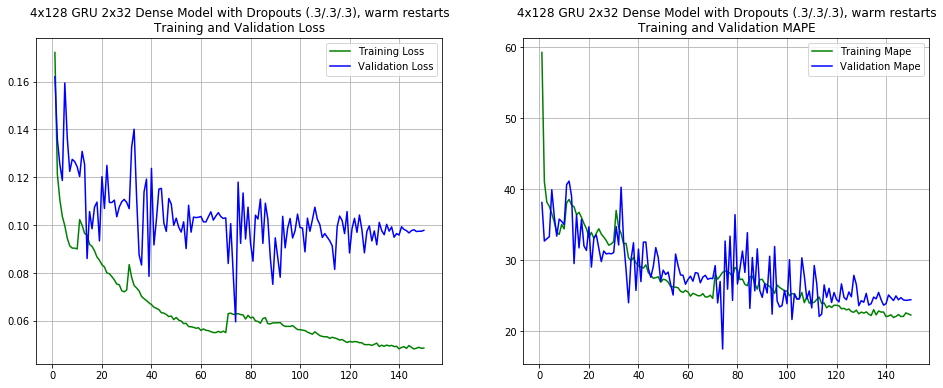

In [37]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation Loss')
plt.grid(True)
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.048272
Validation min loss = 0.059611
Validation min epoch = 73


In [39]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 6.577063
Validation MAE = 8.121972


## 4x128 GRU, 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts max_lr=.01

In [26]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [28]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, reset_after=True))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [29]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [30]:
wr = WarmRestart(min_lr=0.00001,
                 max_lr=0.01,  # keras default lr for rmsprop is 0.001
                 steps_per_epoch=gen_train.__len__(),
                 lr_decay=1,  # 10% decay is 0.9
                 cycle_length=10,  # number of epochs in a cycle
                 mult_factor=2)  # scale factor to increase cycle length after each cycle

In [31]:
histories = []

In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-wr.01-4x128gru-2x32dense-dropout030303-histories-epch50.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-wr.01-4x128gru-2x32dense-dropout030303-epch50.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

In [32]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-wr.01-4x128gru-2x32dense-dropout030303.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    ),
    wr
]

In [45]:
train_to_epoch = 150
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-08 14:08:39.330362

Training Duration = 0:30:54.509269


In [46]:
model.save('base3mrb-wr.01-4x128gru-2x32dense-dropout030303-epch' + str(train_to_epoch) + '.h5')

In [47]:
with open('base3mrb.01-wr.01-4x128gru-2x32dense-dropout030303-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

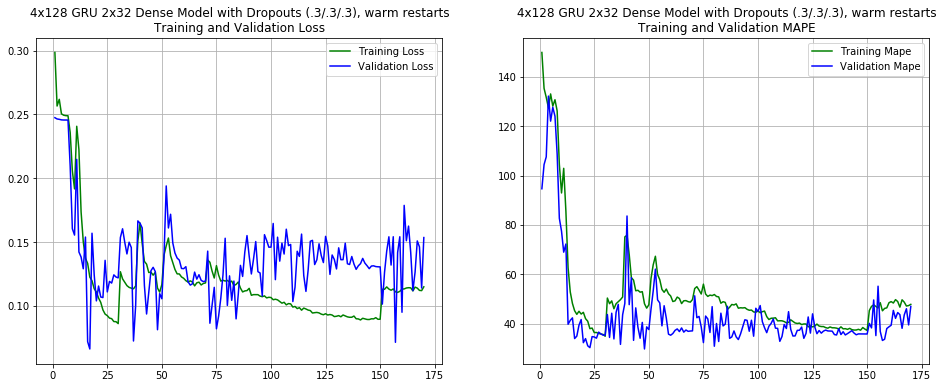

In [48]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation Loss')
plt.grid(True)
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.086087
Validation min loss = 0.066204
Validation min epoch = 16


In [50]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 11.729366
Validation MAE = 9.020265


## 4x128 GRU, 2x32 Dense Model
* **Dropouts** (.3/.3/.3)
* **Warm restarts** min_lr = 0.0001, max_lr=0.002, mult_factor=1

In [51]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [52]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0.3, reset_after=True))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_6 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_7 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
__________

In [53]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [54]:
wr = WarmRestart(min_lr=0.0001,
                 max_lr=0.002,  # keras default lr for rmsprop is 0.001
                 steps_per_epoch=gen_train.__len__(),
                 lr_decay=1,  # 10% decay is 0.9
                 cycle_length=10,  # number of epochs in a cycle
                 mult_factor=1)  # scale factor to increase cycle length after each cycle

In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base3mrb-wr-mult1-4x128gru-2x32dense-dropout030303-histories-epch50.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base3mrb-wr-mult1-4x128gru-2x32dense-dropout030303-epch50.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

In [55]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3mrb-wr-mult1-4x128gru-2x32dense-dropout030303.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    ),
    wr
]

In [56]:
train_to_epoch = 100
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-08 15:28:33.996023

Training Duration = 2:37:07.604313


In [57]:
model.save('base3mrb-wr-mult1-4x128gru-2x32dense-dropout030303-epch' + str(train_to_epoch) + '.h5')

In [58]:
with open('base3mrb-wr-mult1-4x128gru-2x32dense-dropout030303-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

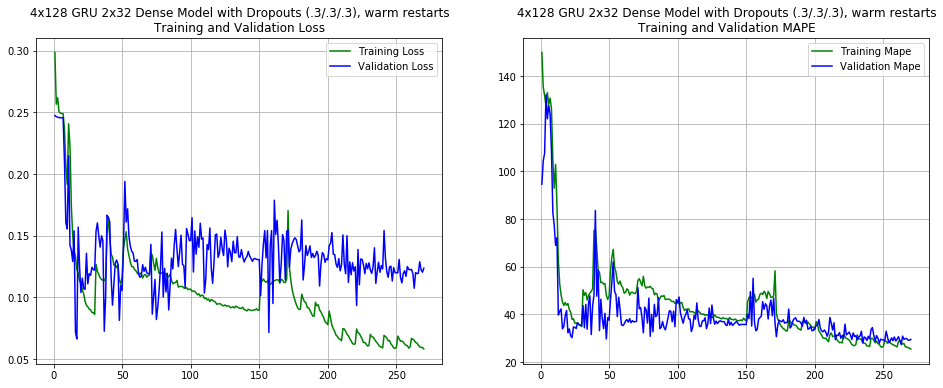

In [59]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation Loss')
plt.grid(True)
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.3/.3/.3), warm restarts\nTraining and Validation MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.058097
Validation min loss = 0.066204
Validation min epoch = 16


In [61]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 7.915692
Validation MAE = 9.020265


# ============= TO BE EDITED ALL BELOW =================

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.4)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.4, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0104-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [54]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.0377 - val_loss: 0.0342 - val_mean_absolute_percentage_error: 17.3515
Epoch 2/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3671 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 14.3414
Epoch 3/50
 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.3488 - val_loss: 0.0324 - val_mean_absolute_percentage_error: 13.9184
Epoch 4/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3482 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 12.3876
Epoch 5/50
 - 94s - loss: 0.0169 - mean_absolute_percentage_error: 11.3245 - val_loss: 0.0345 - val_mean_absolute_percentage_error: 15.3350
Epoch 6/50
 - 94s - loss: 0.0166 - mean_absolute_percentage_error: 11.1723 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 13.8063
Epoch 7/50
 - 94s - loss: 0.0160 - mean_absolute_percentage_error: 10.8153 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 14.1514
Epoch 8/50
 - 95s - 

In [55]:
# histories = []  ## if first training session
histories.append(history.history)

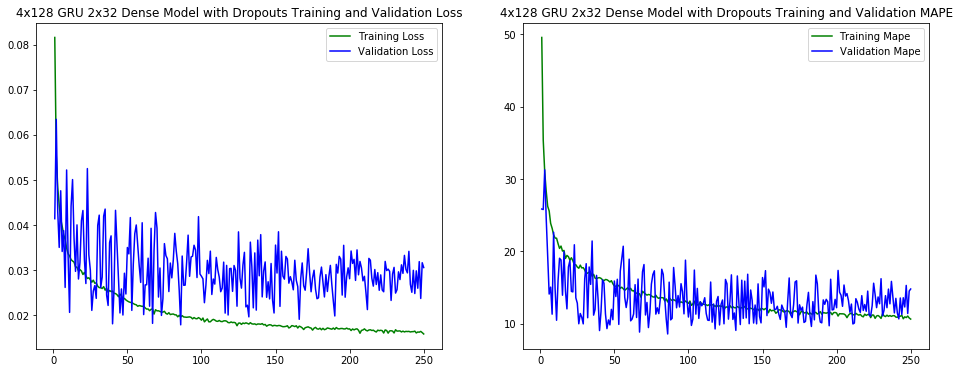

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [60]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.681443
Validation MAE = 2.520015


In [61]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
mrb_train_preds.shape

(29754, 1)

In [62]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

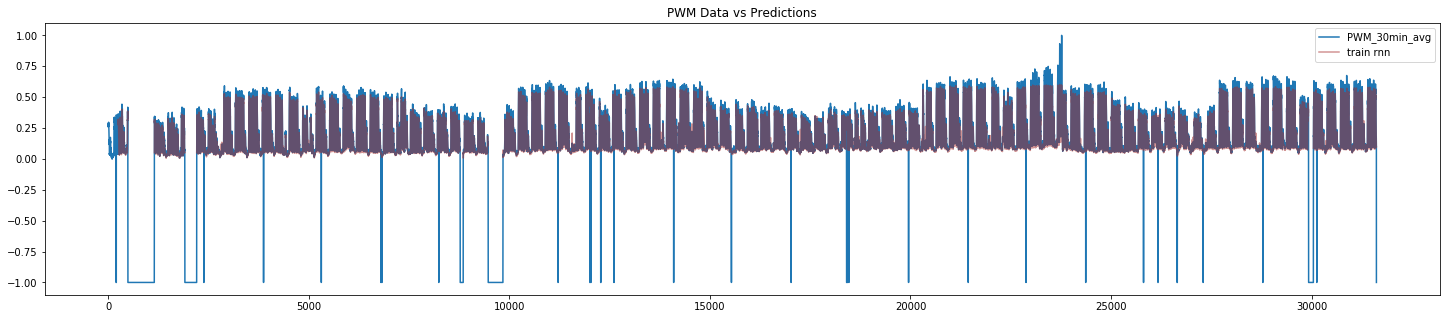

In [63]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

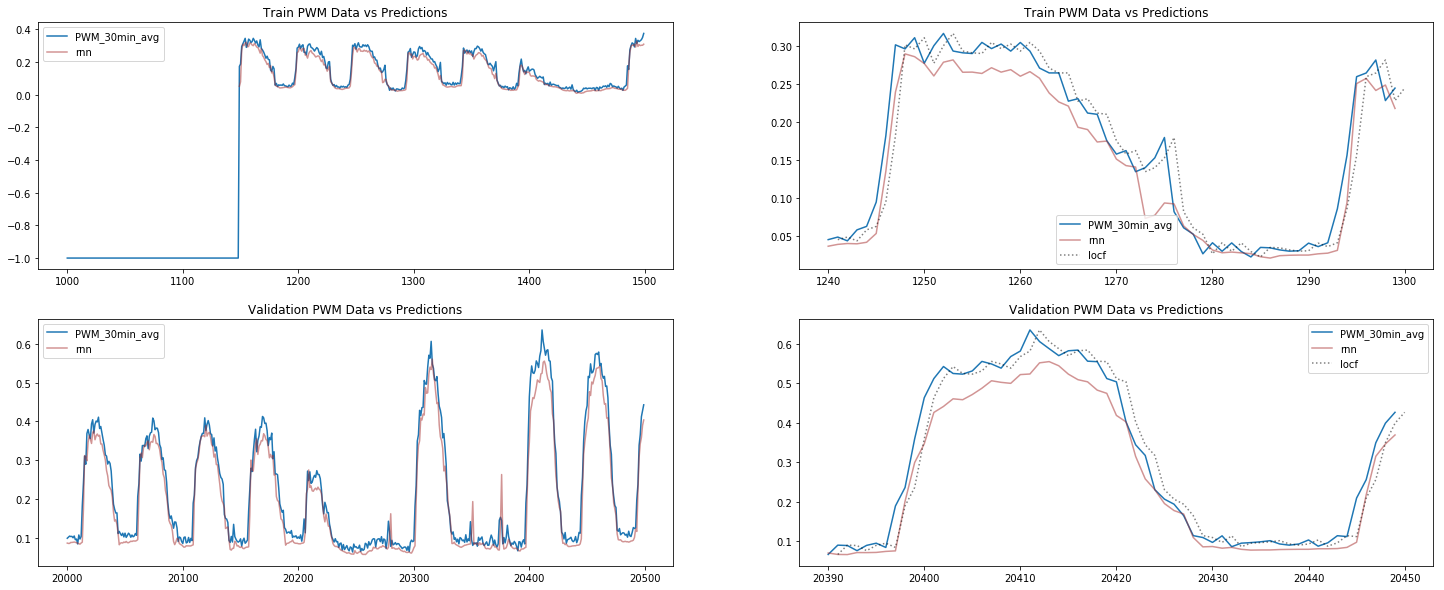

In [64]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [65]:
model.save('base-4x128gru-2x32dense-dropout0104.h5')

In [66]:
with open('base-4x128gru-2x32dense-dropout0104-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.2) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout-1x0202.h5'))
model.summary()

In [22]:
callbacks = [
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [54]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2,
                              callbacks=callbacks)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))


Training start time = 2019-01-29 13:48:37.069840
Epoch 1/50
 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.2550 - val_loss: 0.0582 - val_mean_absolute_percentage_error: 25.2833
Epoch 2/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1358 - val_loss: 0.0576 - val_mean_absolute_percentage_error: 24.6033
Epoch 3/50
 - 83s - loss: 0.0132 - mean_absolute_percentage_error: 9.1765 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 18.5366
Epoch 4/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.2159 - val_loss: 0.0519 - val_mean_absolute_percentage_error: 19.1926
Epoch 5/50
 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.2520 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 19.2709
Epoch 6/50
 - 82s - loss: 0.0131 - mean_absolute_percentage_error: 9.1308 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 15.9808
Epoch 7/50
 - 82s - loss: 0.0133 - mean_absolute_percentage_error: 9.1344 - val_loss: 0.0581 - val_mean_absolute_perc

In [55]:
# histories = [] # for first training session
histories.append(history.history)

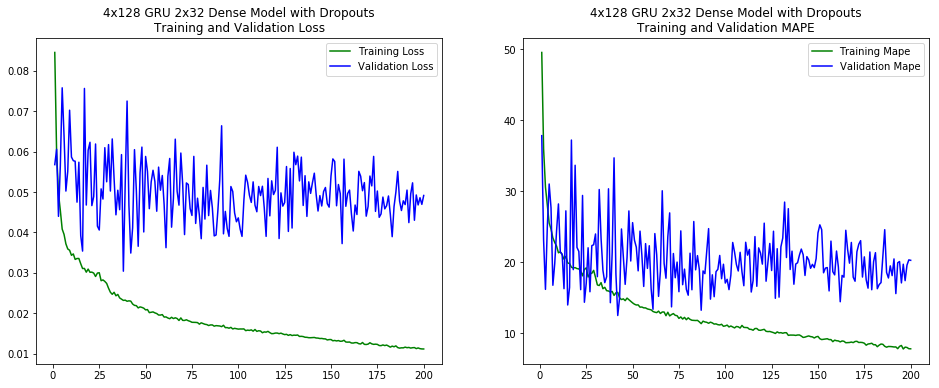

In [56]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [57]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.188571
Validation MAE = 3.235326


In [58]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [59]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

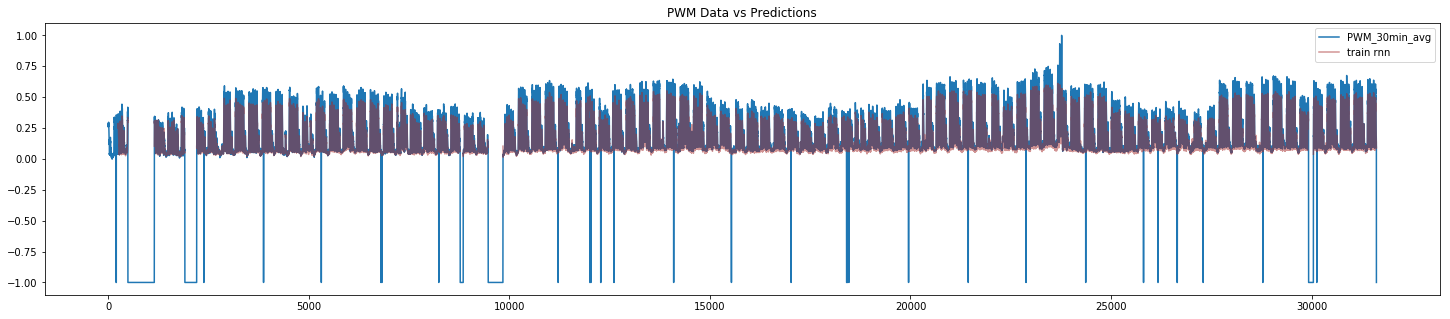

In [60]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

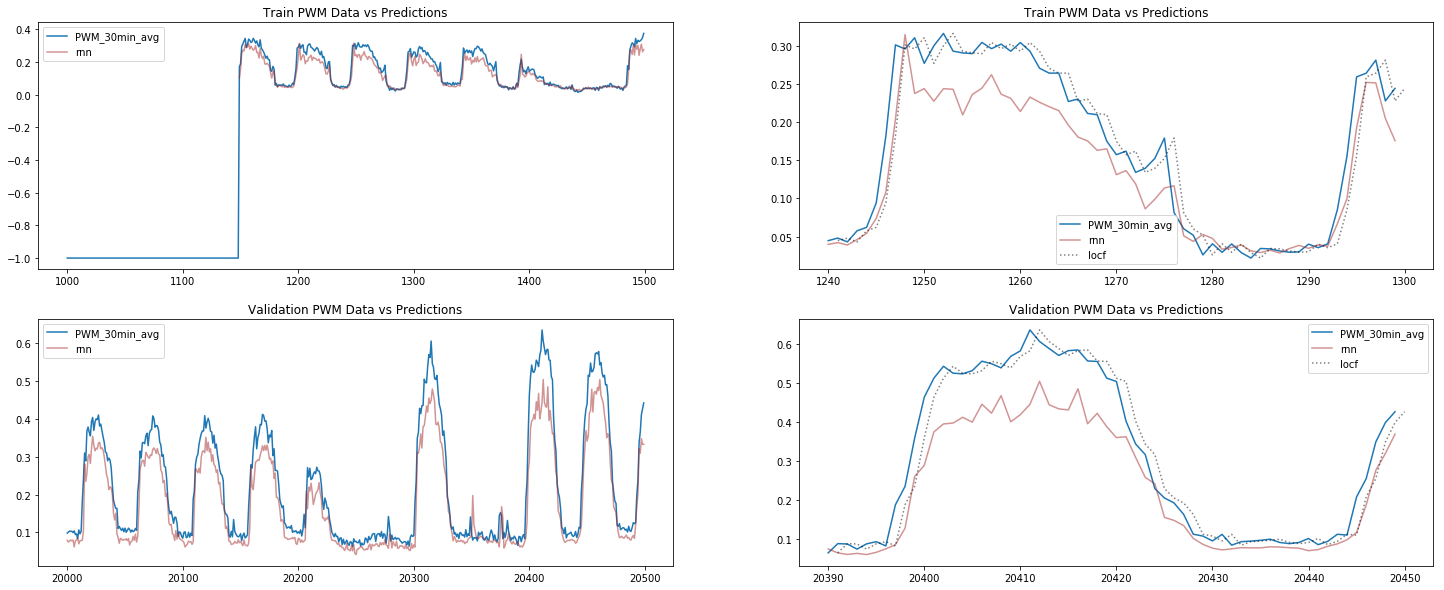

In [61]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [62]:
model.save('base-4x128gru-2x32dense-dropout1x0202.h5')

In [63]:
with open('base-4x128gru-2x32dense-dropout1x0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.05) and Recurrent Dropout (0.05)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.05, recurrent_dropout=0.05, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x005005.h5'))
model.summary()

In [46]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 81s - loss: 0.0143 - mean_absolute_percentage_error: 9.8528 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3009
Epoch 2/50
 - 80s - loss: 0.0144 - mean_absolute_percentage_error: 10.2110 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 10.1580
Epoch 3/50
 - 79s - loss: 0.0142 - mean_absolute_percentage_error: 9.8094 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 10.2294
Epoch 4/50
 - 82s - loss: 0.0141 - mean_absolute_percentage_error: 9.7670 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.2976
Epoch 5/50
 - 81s - loss: 0.0139 - mean_absolute_percentage_error: 9.6537 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 10.4887
Epoch 6/50
 - 82s - loss: 0.0140 - mean_absolute_percentage_error: 9.8895 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 12.1973
Epoch 7/50
 - 81s - loss: 0.0138 - mean_absolute_percentage_error: 9.4852 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9067
Epoch 8/50
 - 81s - loss: 0.0

In [47]:
# histories = [] # for first training session
histories.append(history.history)

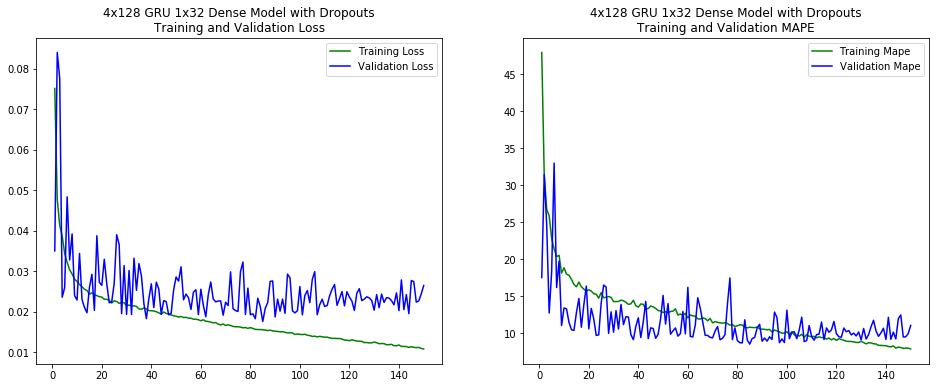

In [48]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [49]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010789
Validation min loss = 0.017562
Validation min epoch = 84


In [50]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.147767
Validation MAE = 1.868231


In [51]:
mrb_train_df['PWM_30min_avg'].min()

gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape


(29754, 1)

In [52]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

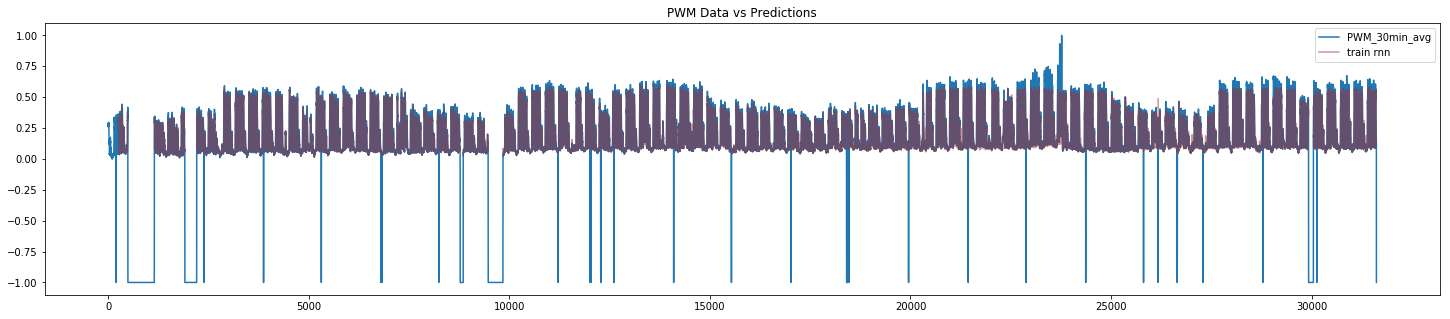

In [53]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

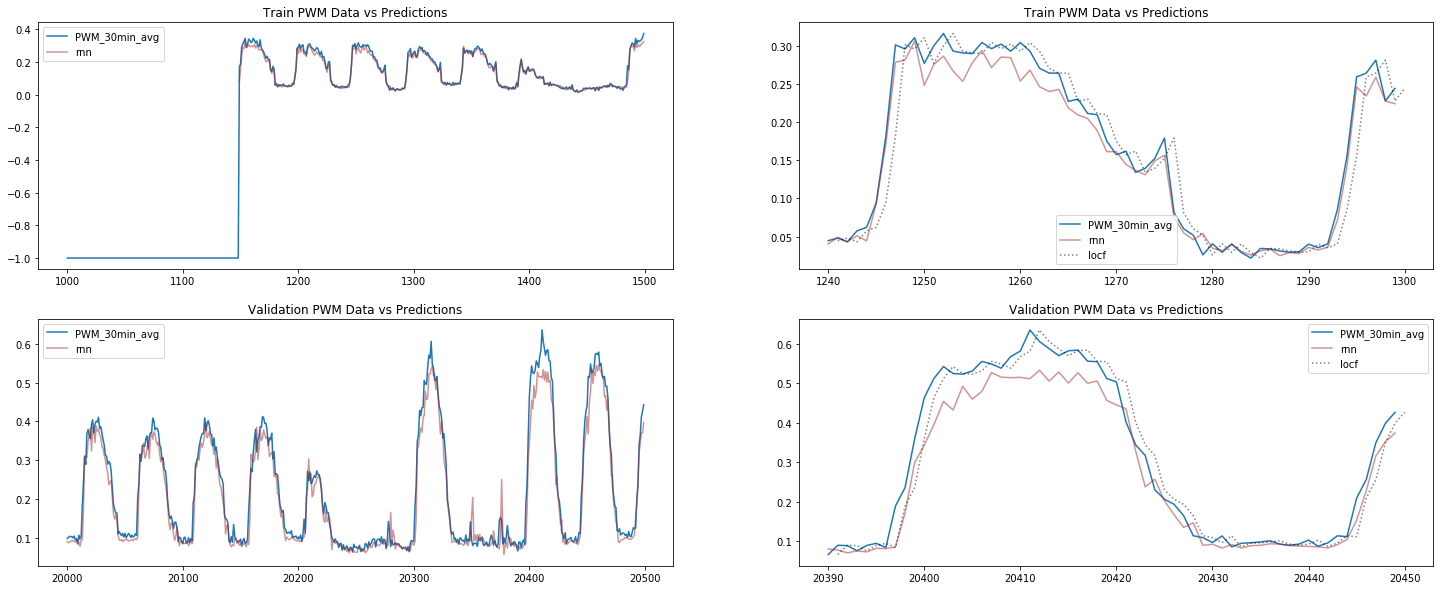

In [54]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [55]:
model.save('base-4x128gru-2x32dense-dropout1x005005.h5')

In [56]:
with open('base-4x128gru-2x32dense-dropout1x005005-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Single Layer Dropout (0.1) and Recurrent Dropout (0.1)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, mrb_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

In [20]:
gen_train = mu.DataGenerator(mrb_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_split) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [21]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-histories-epch150.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout1x0101-epch150.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [22]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 82s - loss: 0.0124 - mean_absolute_percentage_error: 8.7079 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 14.1360
Epoch 2/50
 - 80s - loss: 0.0125 - mean_absolute_percentage_error: 8.5908 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 14.8605
Epoch 3/50
 - 81s - loss: 0.0122 - mean_absolute_percentage_error: 8.6965 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 10.7497
Epoch 4/50
 - 81s - loss: 0.0123 - mean_absolute_percentage_error: 8.5570 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 11.2606
Epoch 5/50
 - 79s - loss: 0.0121 - mean_absolute_percentage_error: 8.6427 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 11.5558
Epoch 6/50
 - 79s - loss: 0.0119 - mean_absolute_percentage_error: 8.4144 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 10.6531
Epoch 7/50
 - 79s - loss: 0.0120 - mean_absolute_percentage_error: 8.4668 - val_loss: 0.0414 - val_mean_absolute_percentage_error: 15.5226
Epoch 8/50
 - 79s - loss: 0

In [23]:
# histories = [] # for first training session
histories.append(history.history)

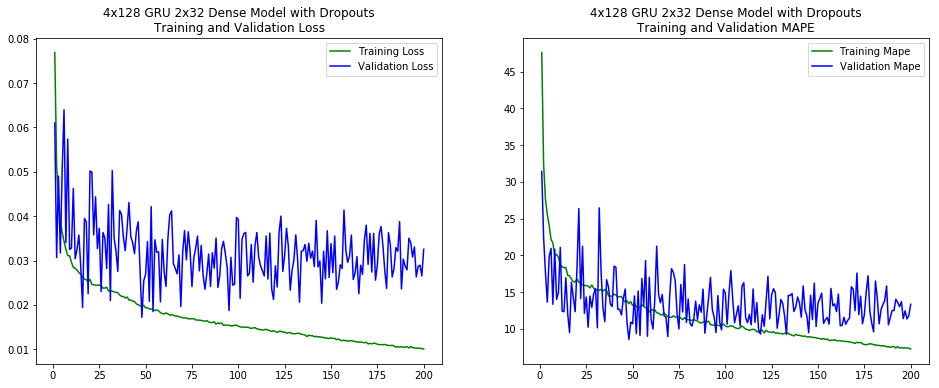

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010057
Validation min loss = 0.017197
Validation min epoch = 47


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_df['PWM_30min_avg'].max() - mrb_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.069913
Validation MAE = 1.829380


In [27]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

(29754, 1)

In [28]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds[j]
        j += 1
mrb_train_preds_withnan.shape

(31616, 1)

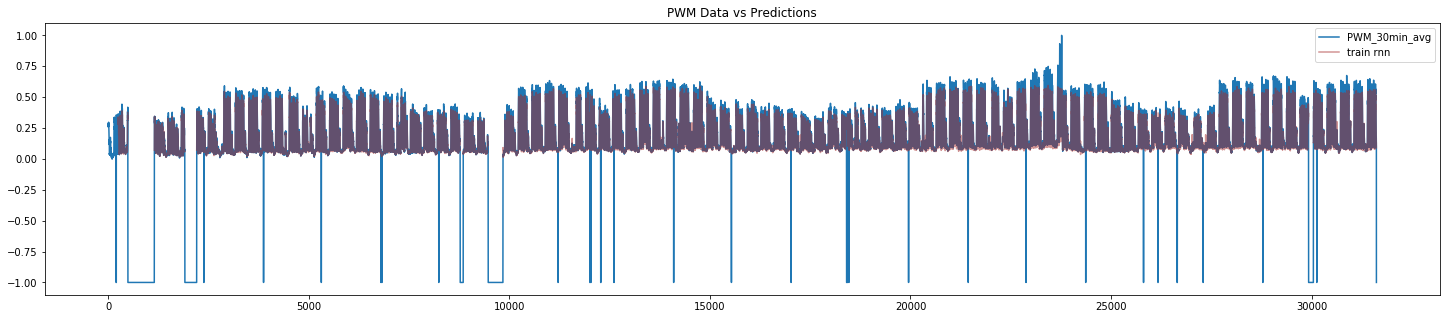

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(mrb_train_data.shape[0]), mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

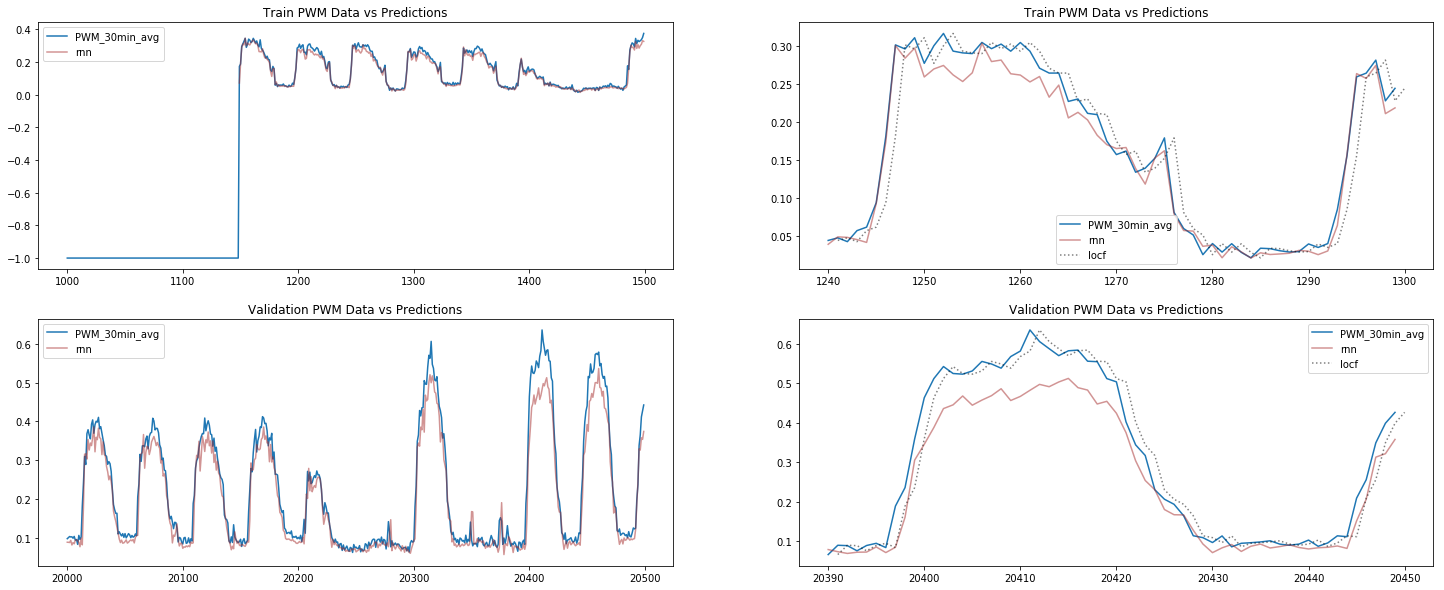

In [30]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), mrb_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), mrb_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), mrb_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), mrb_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), mrb_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), mrb_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), mrb_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), mrb_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-4x128gru-2x32dense-dropout1x0101.h5')

In [32]:
with open('base-4x128gru-2x32dense-dropout1x0101-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)